In [ ]:
# !git clone https://github.com/Pseudophoenix/SoilDataset.git

^C


Cloning into 'SoilDataset'...
Updating files:   1% (17/1573)
Updating files:   2% (32/1573)
Updating files:   3% (48/1573)
Updating files:   4% (63/1573)
Updating files:   5% (79/1573)
Updating files:   6% (95/1573)
Updating files:   7% (111/1573)
Updating files:   8% (126/1573)
Updating files:   9% (142/1573)
Updating files:  10% (158/1573)
Updating files:  11% (174/1573)
Updating files:  12% (189/1573)
Updating files:  13% (205/1573)
Updating files:  14% (221/1573)
Updating files:  15% (236/1573)
Updating files:  16% (252/1573)
Updating files:  17% (268/1573)
Updating files:  18% (284/1573)
Updating files:  19% (299/1573)
Updating files:  20% (315/1573)
Updating files:  21% (331/1573)
Updating files:  22% (347/1573)
Updating files:  23% (362/1573)
Updating files:  24% (378/1573)
Updating files:  25% (394/1573)
Updating files:  26% (409/1573)
Updating files:  27% (425/1573)
Updating files:  28% (441/1573)
Updating files:  29% (457/1573)
Updating files:  30% (472/1573)
Updating files: 

In [4]:
# DRIVE_ROOT_PATH="/content/drive/MyDrive/SoilDataset"
DRIVE_ROOT_PATH="./"

In [ ]:
import os
import csv
import datetime
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from transformers import ViTForImageClassification, ViTConfig
from transformers import AdamW
from tqdm import tqdm
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier


## Image Visualization

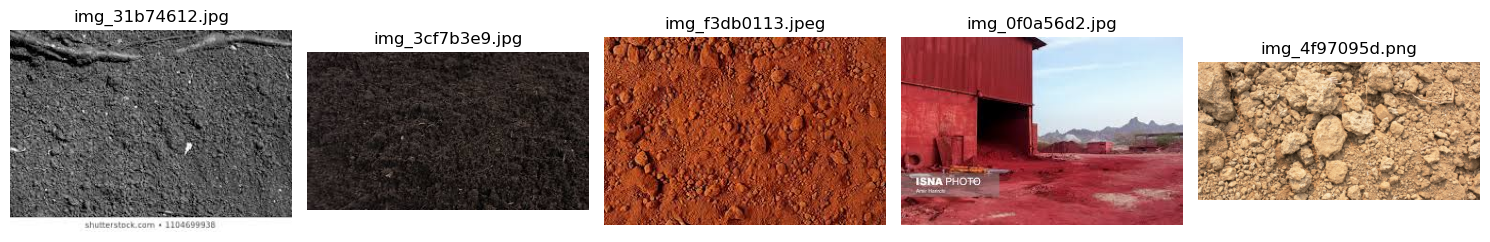

In [19]:

def visualize_random_images(directory, num_images=5):
    # Get all image files from the directory
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
    image_files = [f for f in os.listdir(directory)
                  if os.path.splitext(f)[1].lower() in image_extensions]

    if not image_files:
        print("No images found in the directory.")
        return

    # Select random images
    selected_images = random.sample(image_files, min(num_images, len(image_files)))

    # Create figure
    fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
    if len(selected_images) == 1:
        axes = [axes]  # Make it iterable if only one image

    for ax, img_file in zip(axes, selected_images):
        img_path = os.path.join(directory, img_file)
        try:
            img = imread(img_path)
            ax.imshow(img)
            ax.set_title(os.path.basename(img_file))
            ax.axis('off')
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")
            ax.axis('off')  # Turn off axis if image couldn't be loaded

    plt.tight_layout()
    plt.show()

# Usage example:
directory_path = DRIVE_ROOT_PATH+"/soilclassification/soilclassification2025/test"  # Replace with your directory path
visualize_random_images(directory_path)

## Resizing of Images

64x64 Images:


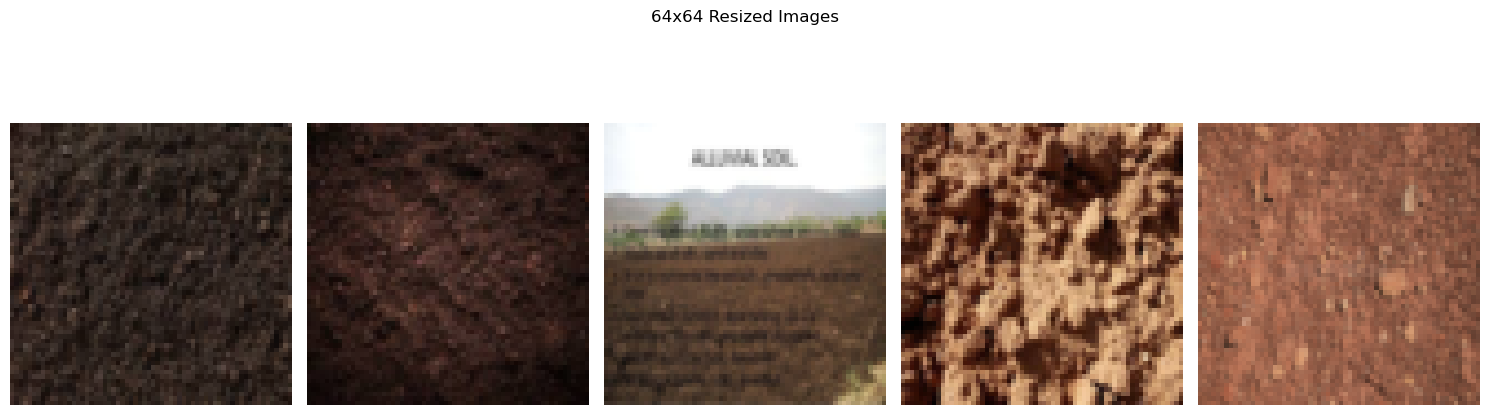

128x128 Images:


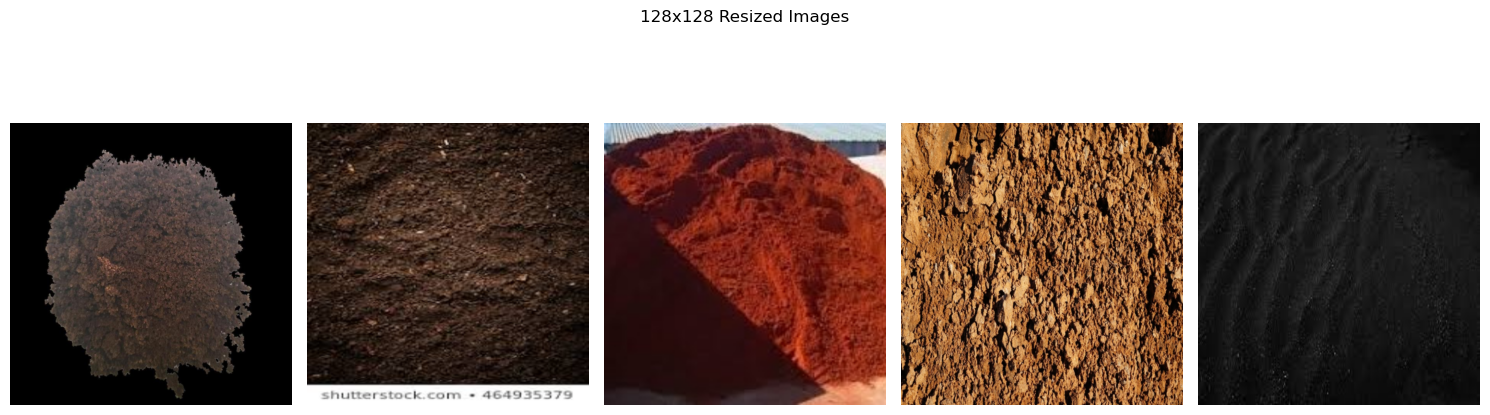

In [20]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

def visualize_images(loader, title):
    # Get a batch of images
    images = next(iter(loader))

    # Convert from tensor to numpy and change from CxHxW to HxWxC
    images = images.numpy().transpose((0, 2, 3, 1))

    # Clip values to [0, 1] in case of normalization
    images = images.clip(0, 1)

    # Plot images
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    if len(images) == 1:
        axes = [axes]

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Define transformations
transform_64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

transform_128 = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Directory path (change this to your image directory)
image_dir = directory_path

# Create datasets
dataset_64 = ImageDataset(image_dir, transform=transform_64)
dataset_128 = ImageDataset(image_dir, transform=transform_128)

# Create loaders - we'll set batch_size to 5 to match your request
loader_64 = DataLoader(dataset_64, batch_size=5, shuffle=True)
loader_128 = DataLoader(dataset_128, batch_size=5, shuffle=True)

# Visualize images
print("64x64 Images:")
visualize_images(loader_64, "64x64 Resized Images")

print("128x128 Images:")
visualize_images(loader_128, "128x128 Resized Images")

## Extract Pixel Features

In [21]:
import cv2
import numpy as np

def extract_pixel_features(image_path, target_size=(64, 64)):
    """
    Basic pixel-based feature extraction

    Args:
        image_path: Path to the input image
        target_size: Target size for resizing (width, height)

    Returns:
        A flattened array of pixel values as features
    """
    # Read the image
    img = cv2.imread(image_path)

    # Convert to grayscale (optional - removes color information)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize the image to a fixed size
    resized_img = cv2.resize(gray_img, target_size)

    # Normalize pixel values to [0, 1]
    normalized_img = resized_img / 255.0

    # Flatten the image to a 1D array (feature vector)
    features = normalized_img.flatten()

    return features

# Example usage
if __name__ == "__main__":
    features = extract_pixel_features(DRIVE_ROOT_PATH+"soilclassification/soilclassification2025/test/img_000f12db.jpg")
    print(f"Extracted features shape: {features.shape}")
    print(f"First 10 feature values: {features[:10]}")

Extracted features shape: (4096,)
First 10 feature values: [0.84313725 0.82352941 0.78823529 0.81176471 0.82352941 0.82352941
 0.80784314 0.81960784 0.81960784 0.81176471]


## Random Forest Classifier

In [13]:
# 1. Define image preprocessing transformations (same as before)
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Resize images to 64x64
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Function to load and preprocess images with limited samples per class (same as before)
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    all_files = os.listdir(folder)

    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img.numpy())
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 3. Load your dataset with limited samples per class (same as before)
dataset_path = DRIVE_ROOT_PATH+'soilclassification/soilclassification2025/train'
classes = os.listdir(dataset_path)
samples_per_class = 400  # Set the number of images you want per class

X = []
y = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
    
    X.extend(images)
    
    y.extend(labels)

    # print(X[0])
    # print(y[0])
    print(f"Loaded {len(images)} images from class {class_name}")

# 4. Convert data to numpy arrays and reshape (same as before)
X = np.array(X)
y = np.array(y)

n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)  # Flatten all dimensions except the first

# 5. Encode labels (same as before)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# X_train=X
# y_train=y
# X_test=
# y_test=
# 6. Split data into train and test sets (same as before)
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining on {X_train.shape[0]} samples ({len(classes)} classes)")
print(f"Testing on {X_test.shape[0]} samples")

# 7. Create and train Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    criterion='gini',        # Splitting criterion
    max_depth=None,          # Maximum depth of the tree
    min_samples_split=2,     # Minimum number of samples required to split
    min_samples_leaf=1,      # Minimum number of samples at leaf node
    max_features='sqrt',     # Number of features to consider at each split
    bootstrap=True,          # Bootstrap samples when building trees
    random_state=42,
    n_jobs=-1               # Use all processors
)

rf_classifier.fit(X_train, y_train)

# Save the model
import joblib
model_name = DRIVE_ROOT_PATH+"trainedmodels/RandomForest_v1_400_images"
joblib.dump(rf_classifier, model_name + '.pkl')

# 8. Evaluate the model
y_pred = rf_classifier.predict(X_test)
y_probs = rf_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 9. Save performance metrics to a CSV file (same as before)
def save_metrics_to_csv(model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(classes),
        'total_samples': X_flat.shape[0]
    }

    report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    for class_name in label_encoder.classes_:
        metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    file_exists = os.path.isfile(filename)

    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

save_metrics_to_csv(
    model_name=model_name,
    samples_per_class=samples_per_class,
    accuracy=accuracy,
    report=classification_report(y_test, y_pred, target_names=label_encoder.classes_)
)

print(f"\nMetrics saved to 'model_performance.csv'")

Loaded 400 images from class Alluvial soil
Loaded 231 images from class Black Soil
Loaded 199 images from class Clay soil
Loaded 264 images from class Red soil

Training on 875 samples (4 classes)
Testing on 219 samples

Accuracy: 0.9498

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.95      0.94      0.94        80
   Black Soil       0.98      0.93      0.96        46
    Clay soil       0.86      0.93      0.89        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           0.95       219
    macro avg       0.95      0.95      0.95       219
 weighted avg       0.95      0.95      0.95       219


Metrics saved to 'model_performance.csv'


## Grid SearchCV for RandomForest

In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],     # Minimum number of samples required to split
    'min_samples_leaf': [1, 2, 4],       # Minimum number of samples at leaf node
    'max_features': ['sqrt', 'log2'],    # Number of features to consider at each split
    'bootstrap': [True, False]           # Whether bootstrap samples are used
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        criterion='gini',
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=3,                   # 3-fold cross-validation
    scoring='accuracy',     # Scoring metric
    verbose=2,             # Verbosity level
    n_jobs=-1              # Use all processors
)

# Perform the grid search (this may take a while)
print("Starting grid search...")
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("\nBest parameters found:")
print(best_params)

# Evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model accuracy: {accuracy:.4f}")

# Save the best model
model_name = DRIVE_ROOT_PATH + "trainedmodels/RandomForest_grid_search_best"
joblib.dump(best_model, model_name + '.pkl')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Save metrics to CSV (using your existing function)
save_metrics_to_csv(
    model_name=model_name,
    samples_per_class=samples_per_class,
    accuracy=accuracy,
    report=classification_report(y_test, y_pred, target_names=label_encoder.classes_)
)

Starting grid search...
Fitting 3 folds for each of 432 candidates, totalling 1296 fits

Best parameters found:
{'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

Best model accuracy: 0.8333

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.71      0.83      0.77         6
   Black Soil       1.00      0.83      0.91         6
    Clay soil       0.67      0.67      0.67         6
     Red soil       1.00      1.00      1.00         6

     accuracy                           0.83        24
    macro avg       0.85      0.83      0.84        24
 weighted avg       0.85      0.83      0.84        24



## Finding the labels for provided test_ids

In [30]:
# for class_name in classes:
    # class_path = os.path.join(dataset_path, class_name)
X_test=[]
test_folder = DRIVE_ROOT_PATH+"soilclassification\soilclassification2025\\test"  # Make sure this points to your test 
def load_images_from_folder_without_labels(folder, max_samples=None):
    images = []
    all_files = os.listdir(folder)

    # if max_samples is not None and len(all_files) > max_samples:
    #     selected_files = random.sample(all_files, max_samples)
    # else:
    selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img.numpy())
            # labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images
images = load_images_from_folder_without_labels(test_folder, max_samples=samples_per_class)
X_test.extend(images)
X_test = np.array(X_test)

n_samples = X_test.shape[0]
X_test = X_test.reshape(n_samples, -1)  # Flatten all dimensions except the first

# 5. Encode labels (same as before)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# 8. Evaluate the model
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)
y_probs

array([[0.46      , 0.05333333, 0.34666667, 0.14      ],
       [0.04      , 0.23166667, 0.28166667, 0.44666667],
       [0.35      , 0.        , 0.24666667, 0.40333333],
       ...,
       [0.015     , 0.        , 0.97      , 0.015     ],
       [0.05666667, 0.01      , 0.28166667, 0.65166667],
       [0.        , 0.005     , 0.09      , 0.905     ]])

In [31]:
import csv
import os

# Assuming class_path is defined as the path to your test images folder
test_folder = DRIVE_ROOT_PATH+"soilclassification\soilclassification2025\\test"  # Make sure this points to your test images directory
test_files = os.listdir(test_folder)

# Get the predicted class names (reverse the label encoding)
predicted_class_names = label_encoder.inverse_transform(y_pred)

# Create a list of tuples containing (image_name, predicted_class)
submission_data = list(zip(test_files, predicted_class_names))

# Define the CSV file path
submission_file = DRIVE_ROOT_PATH + 'submission_random_forest_best.csv'

# Write to CSV
with open(submission_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['image_id', 'soil_type'])  # Write header
    writer.writerows(submission_data)  # Write data rows

print(f"Submission file saved to {submission_file}")

Submission file saved to ./submission_random_forest_best.csv


## XGBoost Classifier

In [23]:
# 1. Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Resize images to 64x64
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Function to load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensure RGB format
            img = transform(img)                       # Apply transformations
            images.append(img.numpy())                 # Convert to numpy array
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 3. Load your dataset (replace with your actual paths)
# Assuming you have a directory structure like:
# dataset/
#   class1/
#   class2/
#   ...

dataset_path = DRIVE_ROOT_PATH+'soilclassification/soilclassification2025/train'
classes = os.listdir(dataset_path)

X = []
y = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images, labels = load_images_from_folder(class_path, class_name)
    X.extend(images)
    y.extend(labels)

# 4. Convert data to numpy arrays and reshape
X = np.array(X)
y = np.array(y)

# Flatten the images (XGBoost expects 2D data)
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)  # Flatten all dimensions except the first

# 5. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 7. Create and train XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class classification
    num_class=len(classes),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_classifier.fit(X_train, y_train)

# 8. Evaluate the model
y_pred = xgb_classifier.predict(X_test)
y_probs = xgb_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 9. Save the model (optional)
xgb_classifier.save_model('xgb_image_classifier.model')

KeyboardInterrupt: 

### 30 Images Test

In [27]:
# 1. Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Resize images to 64x64
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Function to load and preprocess images with limited samples per class
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    all_files = os.listdir(folder)

    # If max_samples is specified and there are more files than max_samples,
    # randomly sample without replacement
    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensure RGB format
            img = transform(img)                     # Apply transformations
            images.append(img.numpy())               # Convert to numpy array
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 3. Load your dataset with limited samples per class
dataset_path = DRIVE_ROOT_PATH+'soilclassification/soilclassification2025/train'
classes = os.listdir(dataset_path)
samples_per_class = 30  # Set the number of images you want per class

X = []
y = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
    X.extend(images)
    y.extend(labels)
    print(f"Loaded {len(images)} images from class {class_name}")

# 4. Convert data to numpy arrays and reshape
X = np.array(X)
y = np.array(y)

# Flatten the images (XGBoost expects 2D data)
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)  # Flatten all dimensions except the first

# 5. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining on {X_train.shape[0]} samples ({len(classes)} classes)")
print(f"Testing on {X_test.shape[0]} samples")

# 7. Create and train XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class classification
    num_class=len(classes),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_classifier.fit(X_train, y_train)
model_name = DRIVE_ROOT_PATH+"/trainedmodels/XGBoost_v1_60_images" 
xgb_classifier.save_model(model_name)
# 8. Evaluate the model
y_pred = xgb_classifier.predict(X_test)
y_probs = xgb_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Loaded 30 images from class Alluvial soil
Loaded 30 images from class Black Soil
Loaded 30 images from class Clay soil
Loaded 30 images from class Red soil

Training on 96 samples (4 classes)
Testing on 24 samples

Accuracy: 0.7917

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.67      0.67      0.67         6
   Black Soil       1.00      1.00      1.00         6
    Clay soil       0.60      0.50      0.55         6
     Red soil       0.86      1.00      0.92         6

     accuracy                           0.79        24
    macro avg       0.78      0.79      0.78        24
 weighted avg       0.78      0.79      0.78        24



c:\Users\alok4\anaconda3\envs\GPU_ENV\lib\site-packages\xgboost\core.py:158: UserWarning: [16:19:53] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


### 60 Images

In [25]:
# 1. Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Resize images to 64x64
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Function to load and preprocess images with limited samples per class
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    all_files = os.listdir(folder)

    # If max_samples is specified and there are more files than max_samples,
    # randomly sample without replacement
    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensure RGB format
            img = transform(img)                     # Apply transformations
            images.append(img.numpy())               # Convert to numpy array
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 3. Load your dataset with limited samples per class
dataset_path = DRIVE_ROOT_PATH+'soilclassification/soilclassification2025/train'
classes = os.listdir(dataset_path)
samples_per_class = 60  # Set the number of images you want per class

X = []
y = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
    X.extend(images)
    y.extend(labels)
    print(f"Loaded {len(images)} images from class {class_name}")

# 4. Convert data to numpy arrays and reshape
X = np.array(X)
y = np.array(y)

# Flatten the images (XGBoost expects 2D data)
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)  # Flatten all dimensions except the first

# 5. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining on {X_train.shape[0]} samples ({len(classes)} classes)")
print(f"Testing on {X_test.shape[0]} samples")

# 7. Create and train XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class classification
    num_class=len(classes),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_classifier.fit(X_train, y_train)
model_name = DRIVE_ROOT_PATH+"/trainedmodels/XGBoost_v1_60_images"  # Example: "XGBoost_64x64_30samples"
xgb_classifier.save_model(model_name)
# 8. Evaluate the model
y_pred = xgb_classifier.predict(X_test)
y_probs = xgb_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 9. Save performance metrics to a CSV file
def save_metrics_to_csv(model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    # Prepare the data to save
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(classes),
        'total_samples': X_flat.shape[0]
    }

    # Add precision, recall, f1-score for each class
    report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    for class_name in label_encoder.classes_:
        metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    # Check if file exists to write header
    file_exists = os.path.isfile(filename)

    # Write to CSV
    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

# Specify your model name (customize this for each experiment)


# Call the function to save metrics
save_metrics_to_csv(
    model_name=model_name,
    samples_per_class=samples_per_class,
    accuracy=accuracy,
    report=classification_report(y_test, y_pred, target_names=label_encoder.classes_)
)

print(f"\nMetrics saved to 'model_performance.csv'")

Loaded 60 images from class Alluvial soil
Loaded 60 images from class Black Soil
Loaded 60 images from class Clay soil
Loaded 60 images from class Red soil

Training on 192 samples (4 classes)
Testing on 48 samples

Accuracy: 0.8333

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.75      0.75      0.75        12
   Black Soil       0.92      0.92      0.92        12
    Clay soil       0.73      0.67      0.70        12
     Red soil       0.92      1.00      0.96        12

     accuracy                           0.83        48
    macro avg       0.83      0.83      0.83        48
 weighted avg       0.83      0.83      0.83        48


Metrics saved to 'model_performance.csv'


c:\Users\alok4\anaconda3\envs\GPU_ENV\lib\site-packages\xgboost\core.py:158: UserWarning: [16:14:57] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


### 400 Images

In [32]:
# 1. Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),          # Resize images to 64x64
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize(                 # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Function to load and preprocess images with limited samples per class
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    all_files = os.listdir(folder)

    # If max_samples is specified and there are more files than max_samples,
    # randomly sample without replacement
    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Ensure RGB format
            img = transform(img)                     # Apply transformations
            images.append(img.numpy())               # Convert to numpy array
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 3. Load your dataset with limited samples per class
dataset_path = DRIVE_ROOT_PATH+'soilclassification/soilclassification2025/train'
classes = os.listdir(dataset_path)
samples_per_class = 400  # Set the number of images you want per class

X = []
y = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
    X.extend(images)
    y.extend(labels)
    print(f"Loaded {len(images)} images from class {class_name}")

# 4. Convert data to numpy arrays and reshape
X = np.array(X)
y = np.array(y)

# Flatten the images (XGBoost expects 2D data)
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)  # Flatten all dimensions except the first

# 5. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining on {X_train.shape[0]} samples ({len(classes)} classes)")
print(f"Testing on {X_test.shape[0]} samples")

# 7. Create and train XGBoost classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class classification
    num_class=len(classes),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_classifier.fit(X_train, y_train)
model_name = DRIVE_ROOT_PATH+"/trainedmodels/XGBoost_v1_400_images"  # Example: "XGBoost_64x64_30samples"
xgb_classifier.save_model(model_name)
# 8. Evaluate the model
y_pred = xgb_classifier.predict(X_test)
y_probs = xgb_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 9. Save performance metrics to a CSV file
def save_metrics_to_csv(model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    # Prepare the data to save
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(classes),
        'total_samples': X_flat.shape[0]
    }

    # Add precision, recall, f1-score for each class
    report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    for class_name in label_encoder.classes_:
        metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    # Check if file exists to write header
    file_exists = os.path.isfile(filename)

    # Write to CSV
    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

# Specify your model name (customize this for each experiment)


# Call the function to save metrics
save_metrics_to_csv(
    model_name=model_name,
    samples_per_class=samples_per_class,
    accuracy=accuracy,
    report=classification_report(y_test, y_pred, target_names=label_encoder.classes_)
)

print(f"\nMetrics saved to 'model_performance.csv'")

Loaded 400 images from class Alluvial soil
Loaded 231 images from class Black Soil
Loaded 199 images from class Clay soil
Loaded 264 images from class Red soil

Training on 875 samples (4 classes)
Testing on 219 samples


c:\Users\alok4\anaconda3\envs\GPU_ENV\lib\site-packages\xgboost\core.py:158: UserWarning: [16:41:45] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)



Accuracy: 0.9726

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.94      0.99      0.96        80
   Black Soil       1.00      0.96      0.98        46
    Clay soil       0.97      0.93      0.95        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           0.97       219
    macro avg       0.98      0.97      0.97       219
 weighted avg       0.97      0.97      0.97       219


Metrics saved to 'model_performance.csv'


In [ ]:
model_name = DRIVE_ROOT_PATH+"/trainedmodels/XGBoost_v1_60_images"  # Example: "XGBoost_64x64_30samples"
xgb_classifier.save_model(model_name)
# 8. Evaluate the model
y_pred = xgb_classifier.predict(X_test)
y_probs = xgb_classifier.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 9. Save performance metrics to a CSV file
def save_metrics_to_csv(model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    # Prepare the data to save
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(classes),
        'total_samples': X_flat.shape[0]
    }

    # Add precision, recall, f1-score for each class
    report_dict = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    for class_name in label_encoder.classes_:
        metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    # Check if file exists to write header
    file_exists = os.path.isfile(filename)

    # Write to CSV
    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

# Specify your model name (customize this for each experiment)


# Call the function to save metrics
save_metrics_to_csv(
    model_name=model_name,
    samples_per_class=samples_per_class,
    accuracy=accuracy,
    report=classification_report(y_test, y_pred, target_names=label_encoder.classes_)
)

print(f"\nMetrics saved to 'model_performance.csv'")


Accuracy: 0.8125

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.70      0.58      0.64        12
   Black Soil       0.75      1.00      0.86        12
    Clay soil       0.82      0.75      0.78        12
     Red soil       1.00      0.92      0.96        12

     accuracy                           0.81        48
    macro avg       0.82      0.81      0.81        48
 weighted avg       0.82      0.81      0.81        48


Metrics saved to 'model_performance.csv'


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:43:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [29]:
# for class_name in classes:
    # class_path = os.path.join(dataset_path, class_name)
X_test=[]
test_folder = DRIVE_ROOT_PATH+"soilclassification\soilclassification2025\\test"  # Make sure this points to your test 
def load_images_from_folder_without_labels(folder, max_samples=None):
    images = []
    all_files = os.listdir(folder)

    # if max_samples is not None and len(all_files) > max_samples:
    #     selected_files = random.sample(all_files, max_samples)
    # else:
    selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img.numpy())
            # labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images
images = load_images_from_folder_without_labels(test_folder, max_samples=samples_per_class)
X_test.extend(images)
X_test = np.array(X_test)

n_samples = X_test.shape[0]
X_test = X_test.reshape(n_samples, -1)  # Flatten all dimensions except the first

# 5. Encode labels (same as before)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# 8. Evaluate the model
y_pred = xgb_classifier.predict(X_test)
y_probs = xgb_classifier.predict_proba(X_test)
y_probs

array([[0.85659206, 0.01266623, 0.10590067, 0.02484099],
       [0.01393958, 0.0238528 , 0.07761607, 0.8845915 ],
       [0.03492018, 0.02761082, 0.10046149, 0.8370075 ],
       ...,
       [0.01528169, 0.00672774, 0.97022384, 0.00776674],
       [0.02444359, 0.0176522 , 0.17696601, 0.7809382 ],
       [0.00393383, 0.00527187, 0.00625588, 0.98453844]], dtype=float32)

## Grid Search CV

In [ ]:

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(classes),
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found:")
print(best_params)

# Evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model accuracy: {accuracy:.4f}")

# Save the best model
model_name = DRIVE_ROOT_PATH+"/trained models/XGBoost_grid_search_best"
best_model.save_model(model_name)

In [ ]:
!cp /content/SoilDataset/soilclassification/model_performance.csv /content/drive/MyDrive/

In [ ]:
!git config --global user.email "waynerooney0089@gmail.com"
!git config --global user.name "Pseudophoenix"

In [ ]:
!ls

model_performance.csv  SoilDataset
sample_data	       xgb_image_classifier_60_images.model


In [ ]:
!cd SoilDataset  && git push

fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!ls -a

.   .config		   sample_data	xgb_image_classifier_60_images.model
..  model_performance.csv  SoilDataset


In [ ]:
!mv /content/model_performance.csv /content/SoilDataset/soilclassification/

In [ ]:
!mv /content/xgb_image_classifier_60_images.model /content/drive/MyDrive/models

In [ ]:
!mkdir /content/SoilDataset/trained_models

In [ ]:
# https://chat.deepseek.com/a/chat/s/44ebd221-1690-4455-9629-df4ebc3b57aa

## RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions
param_dist = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'n_estimators': randint(50, 300),
    'subsample': uniform(0.5, 0.5),  # Range 0.5-1.0
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'min_child_weight': randint(1, 10),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=len(classes),
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Perform the random search
random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best parameters found:")
print(best_params)

# Evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model accuracy: {accuracy:.4f}")

# Save the best model
model_name = DRIVE_ROOT_PATH+"/trained models/XGBoost_random_search_best"
best_model.save_model(model_name)

## Optuna

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.3 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    """Define the objective function for Optuna to optimize"""
    params = {
        'objective': 'multi:softprob',
        'num_class': len(classes),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**params)

    # Use cross-validation to evaluate the model
    score = cross_val_score(
        model, X_train, y_train,
        cv=3, scoring='accuracy', n_jobs=-1
    ).mean()

    return score

# Create a study object and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Number of trials

# Print the best parameters and value
print("Best trial:")
trial = study.best_trial
print(f"  Value (accuracy): {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Train the best model on the full training set
best_params = trial.params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': len(classes),
    'random_state': 42,
    'n_jobs': -1
})

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest model accuracy on test set: {accuracy:.4f}")

# Save the best model
model_name = DRIVE_ROOT_PATH+"/trainedmodels/XGBoost_optuna_best"
best_model.save_model(model_name)

# Save the study results to a CSV file
optuna_results_df = study.trials_dataframe()
optuna_results_df.to_csv(DRIVE_ROOT_PATH+'optuna_results.csv', index=False)

[I 2025-05-24 06:18:10,624] A new study created in memory with name: no-name-c25411fa-ba3b-41fe-b7f9-ad6389fb6351
[I 2025-05-24 06:19:30,452] Trial 0 finished with value: 0.8154940339740199 and parameters: {'n_estimators': 88, 'learning_rate': 0.2785752071733023, 'max_depth': 3, 'subsample': 0.9412381733722507, 'colsample_bytree': 0.9327463242636687, 'gamma': 0.296244603481705, 'min_child_weight': 2, 'reg_alpha': 0.7378154190023365, 'reg_lambda': 0.5941687252980744}. Best is trial 0 with value: 0.8154940339740199.
[I 2025-05-24 06:23:34,931] Trial 1 finished with value: 0.831187915123729 and parameters: {'n_estimators': 105, 'learning_rate': 0.028302702252805012, 'max_depth': 4, 'subsample': 0.9030307672579314, 'colsample_bytree': 0.8980613645011721, 'gamma': 0.23074339345421552, 'min_child_weight': 3, 'reg_alpha': 0.2850186101916308, 'reg_lambda': 0.6047827157860313}. Best is trial 1 with value: 0.831187915123729.
[I 2025-05-24 06:27:39,066] Trial 2 finished with value: 0.831187915123

## MobileNet

In [ ]:

# 1. Define image preprocessing transformations (same as before)
transform = transforms.Compose([
    transforms.Resize((224, 224)),        # MobileNet typically uses 224x224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Function to load images (same as before)
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    all_files = os.listdir(folder)

    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# Custom Dataset class
class SoilDataset(Dataset):
    def __init__(self, images, labels, label_encoder):
        self.images = images
        self.labels = label_encoder.transform(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# 3. Function to create MobileNet model
def create_mobilenet(model_name='v3', num_classes=5):
    if model_name.lower() == 'v2':
        model = models.mobilenet_v2(pretrained=True)
        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, num_classes)
    elif model_name.lower() == 'v3_small':
        model = models.mobilenet_v3_small(pretrained=True)
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, num_classes)
    elif model_name.lower() == 'v3_large':
        model = models.mobilenet_v3_large(pretrained=True)
        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, num_classes)
    else:
        raise ValueError("Unsupported MobileNet version. Choose 'v2', 'v3_small', or 'v3_large'")
    return model

# 4. Main training function
def train_mobilenet(model_name='v3', samples_per_class=100):
    # Load dataset
    dataset_path = '/content/SoilDataset/soilclassification/soilclassification2025/train'
    classes = os.listdir(dataset_path)

    X = []
    y = []

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
        X.extend(images)
        y.extend(labels)
        print(f"Loaded {len(images)} images from class {class_name}")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Create datasets
    train_dataset = SoilDataset(X_train, y_train, label_encoder)
    test_dataset = SoilDataset(X_test, y_test, label_encoder)

    # Create dataloaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = create_mobilenet(model_name, num_classes=len(classes))
    model = model.to(device)

    # Training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 15

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # Save model
    model_filename = f"{DRIVE_ROOT_PATH}/trainedmodels/MobileNet{model_name.upper()}_{samples_per_class}samples.pth"
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved to {model_filename}")

    # Save metrics
    save_metrics_to_csv(
        model_name=f"MobileNet{model_name.upper()}",
        samples_per_class=samples_per_class,
        accuracy=accuracy,
        report=classification_report(all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True)
    )

# Reuse the same metrics saving function from your XGBoost code
def save_metrics_to_csv(model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(report.keys()) - 3,  # exclude 'micro avg', 'macro avg', 'weighted avg'
        'total_samples': samples_per_class * (len(report.keys()) - 3)
    }

    for class_name in [x for x in report.keys() if x not in ['micro avg', 'macro avg', 'weighted avg']]:
        metrics[f'precision_{class_name}'] = report[class_name]['precision']
        metrics[f'recall_{class_name}'] = report[class_name]['recall']
        metrics[f'f1_{class_name}'] = report[class_name]['f1-score']

    file_exists = os.path.isfile(filename)

    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

# Example usage:
train_mobilenet(model_name='v3', samples_per_class=100)
# or
# train_mobilenet(model_name='v2', samples_per_class=100)

## EffNetBX

In [48]:


# 1. Define image preprocessing transformations (specific to EfficientNet)
def get_effnet_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # EfficientNet typically uses 224x224
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

# 2. Function to load and preprocess images with limited samples per class
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    transform = get_effnet_transforms()
    all_files = os.listdir(folder)

    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 3. Custom Dataset class
class SoilDataset(Dataset):
    def __init__(self, images, labels, label_encoder):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# 4. Function to create EfficientNet model
def create_effnet_model(model_name='b0', num_classes=4):
    """Create EfficientNet model with specified variant"""
    model_map = {
        'b0': models.efficientnet_b0,
        'b1': models.efficientnet_b1,
        'b2': models.efficientnet_b2,
        'b3': models.efficientnet_b3,
        'b4': models.efficientnet_b4,
        'b5': models.efficientnet_b5,
        'b6': models.efficientnet_b6,
        'b7': models.efficientnet_b7
    }

    if model_name.lower() not in model_map:
        raise ValueError(f"Invalid model name. Choose from {list(model_map.keys())}")

    # Load pretrained model
    model = model_map[model_name.lower()](pretrained=True)

    # Modify classifier for our number of classes
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(num_features, num_classes)
    )

    return model

# 5. Main training function
def train_effnet(model_name='b0', samples_per_class=400, num_epochs=10, batch_size=32):
    # Load dataset
    dataset_path = DRIVE_ROOT_PATH+'soilclassification/soilclassification2025/train'
    classes = os.listdir(dataset_path)

    X = []
    y = []

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
        X.extend(images)
        y.extend(labels)
        print(f"Loaded {len(images)} images from class {class_name}")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Create datasets and dataloaders
    train_dataset = SoilDataset(X_train, y_train, label_encoder)
    test_dataset = SoilDataset(X_test, y_test, label_encoder)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = create_effnet_model(model_name, num_classes=len(classes))
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # Save model
    model_save_name = f"EfficientNet{model_name.upper()}_v1_{samples_per_class}images"
    torch.save(model.state_dict(), DRIVE_ROOT_PATH + f"/trainedmodels/{model_save_name}.pth")

    # Save metrics
    save_metrics_to_csv(all_labels=all_labels,
                        all_preds=all_preds,
        model_name=model_save_name,
        samples_per_class=samples_per_class,
        accuracy=accuracy,
        report=classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
    )

    return model

# 6. Save performance metrics (same as your original function)
def save_metrics_to_csv(all_labels, all_preds, model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(label_encoder.classes_),
        'total_samples': len(X_train) + len(X_test)
    }

    report_dict = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True)
    for class_name in label_encoder.classes_:
        metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    file_exists = os.path.isfile(filename)

    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)
# Example usage:
# Train EfficientNetB0 with 100 samples per class for 10 epochs
model = train_effnet(model_name='b0', samples_per_class=400, num_epochs=10)

# To train a different variant (e.g., B4):
# model = train_effnet(model_name='b4', samples_per_class=100, num_epochs=10)

Loaded 400 images from class Alluvial soil
Loaded 231 images from class Black Soil
Loaded 199 images from class Clay soil
Loaded 264 images from class Red soil


c:\Users\alok4\anaconda3\envs\GPU_ENV\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\alok4\anaconda3\envs\GPU_ENV\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.4375, Accuracy: 85.49%
Epoch 2/10, Loss: 0.1854, Accuracy: 94.40%
Epoch 3/10, Loss: 0.1830, Accuracy: 94.40%
Epoch 4/10, Loss: 0.2194, Accuracy: 93.83%
Epoch 5/10, Loss: 0.1576, Accuracy: 95.66%
Epoch 6/10, Loss: 0.1167, Accuracy: 96.69%
Epoch 7/10, Loss: 0.0767, Accuracy: 97.94%
Epoch 8/10, Loss: 0.0641, Accuracy: 97.26%
Epoch 9/10, Loss: 0.0571, Accuracy: 98.17%
Epoch 10/10, Loss: 0.0873, Accuracy: 97.71%

Test Accuracy: 0.9817

Classification Report:
               precision    recall  f1-score   support

Alluvial soil       0.96      0.99      0.98        80
   Black Soil       1.00      0.98      0.99        46
    Clay soil       0.97      0.95      0.96        40
     Red soil       1.00      1.00      1.00        53

     accuracy                           0.98       219
    macro avg       0.98      0.98      0.98       219
 weighted avg       0.98      0.98      0.98       219



In [ ]:

# # 1. Define the same image preprocessing transformations used during training
# def get_effnet_transforms():
#     return transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.485, 0.456, 0.406],
#             std=[0.229, 0.224, 0.225]
#         )
#     ])

# # 2. Function to load test images without labels
# def load_test_images(folder):
#     images = []
#     filenames = []
#     transform = get_effnet_transforms()
    
#     for filename in sorted(os.listdir(folder)):  # sorted for consistent ordering
#         img_path = os.path.join(folder, filename)
#         try:
#             img = Image.open(img_path).convert('RGB')
#             img = transform(img)
#             images.append(img)
#             filenames.append(filename)
#         except Exception as e:
#             print(f"Error loading {img_path}: {e}")
#     return images, filenames

# # 3. Load the trained model
# def load_trained_model(model_path, model_name='b0', num_classes=4):
#     model_map = {
#         'b0': models.efficientnet_b0,
#         'b1': models.efficientnet_b1,
#         'b2': models.efficientnet_b2,
#         'b3': models.efficientnet_b3,
#         'b4': models.efficientnet_b4,
#         'b5': models.efficientnet_b5,
#         'b6': models.efficientnet_b6,
#         'b7': models.efficientnet_b7
#     }
    
#     # Create model architecture
#     model = model_map[model_name.lower()](pretrained=False)
#     num_features = model.classifier[1].in_features
#     model.classifier = nn.Sequential(
#         nn.Dropout(p=0.2, inplace=True),
#         nn.Linear(num_features, num_classes)
#     )
#     # Load trained weights
#     model.load_state_dict(torch.load(model_path))
#     model.eval()
#     return model

# # 4. Perform inference
# def predict_and_save_results(test_folder, model_path, output_csv_path, label_encoder, model_name='b0'):
#     # Load test images
#     test_images, test_filenames = load_test_images(test_folder)
    
#     # Create DataLoader
#     test_dataset = torch.utils.data.TensorDataset(torch.stack(test_images))
#     test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    
#     # Load model
#     num_classes = len(label_encoder.classes_)
#     model = load_trained_model(model_path, model_name, num_classes)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)
    
#     # Make predictions
#     all_preds = []
#     all_probs = []
    
#     with torch.no_grad():
#         for batch in test_loader:
#             inputs = batch[0].to(device)
#             outputs = model(inputs)
#             probs = torch.nn.functional.softmax(outputs, dim=1)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_probs.extend(probs.cpu().numpy())
    
#     # Convert predictions to class names
#     predicted_classes = label_encoder.inverse_transform(all_preds)
    
#     # Save results to CSV
#     with open(output_csv_path, 'w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(['image_id', 'predicted_class', 'probabilities'])
        
#         for filename, pred_class, prob in zip(test_filenames, predicted_classes, all_probs):
#             prob_str = '|'.join([f"{p:.4f}" for p in prob])
#             writer.writerow([filename, pred_class, prob_str])
    
#     print(f"Predictions saved to {output_csv_path}")
    
#     return test_filenames, predicted_classes, all_probs

# # Example usage:
# if __name__ == "__main__":
#     # Define paths
#     # DRIVE_ROOT_PATH = "your/path/here/"  # Update this
#     test_folder = os.path.join(DRIVE_ROOT_PATH, "soilclassification/soilclassification2025/test")
#     model_path = os.path.join(DRIVE_ROOT_PATH, "trainedmodels/EfficientNetB0_v1_100images.pth")
#     output_csv_path = os.path.join(DRIVE_ROOT_PATH, "predictions.csv")
    
#     # You'll need to have the label encoder used during training
#     # If you don't have it saved, you'll need to recreate it with the same class order
#     # Here's an example (you should use the same classes as during training)
#     classes = ['clay', 'loam', 'sand', 'silt']  # Update with your actual classes
#     label_encoder = LabelEncoder()
#     label_encoder.fit(classes)
    
#     # Run prediction
#     filenames, pred_classes, probs = predict_and_save_results(
#         test_folder=test_folder,
#         model_path=model_path,
#         output_csv_path=output_csv_path,
#         label_encoder=label_encoder,
#         model_name='b0'  # Should match the model you trained
#     )

In [50]:

# 1. Define the same preprocessing transformations used during training
def get_effnet_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Must match training size
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

# 2. Custom Dataset class for inference
class InferenceDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image

# 3. Function to load test images
def load_test_images(folder_path, transform):
    images = []
    filenames = []
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff','.webp')):
            try:
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return images, filenames

# 4. Main inference function
def run_inference(model_path, test_folder, output_csv):
    # Load the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Determine model variant from path (e.g., 'b0' from 'EfficientNetB0')
    model_variant = model_path.split('EfficientNet')[1][:2].lower()
    
    # Create model (you'll need to know the number of classes)
    num_classes = 4  # Update this with your actual number of classes
    model = create_effnet_model(model_name=model_variant, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Load and preprocess test images
    transform = get_effnet_transforms()
    test_images, filenames = load_test_images(test_folder, transform)
    
    # Create dataset and dataloader
    dataset = InferenceDataset(test_images, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    # Run inference
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    # Convert numeric predictions to class names
    # Note: You'll need to have the label_encoder used during training
    # If you don't have it, you'll need to recreate it with the same class order
    # Here's one way to handle it:
    classes = sorted(os.listdir(DRIVE_ROOT_PATH + 'soilclassification/soilclassification2025/train'))
    predicted_classes = [classes[pred] for pred in predictions]
    
    # Save results to CSV
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['image_id', 'soil_type'])
        writer.writerows(zip(filenames, predicted_classes))
    
    print(f"Inference complete. Results saved to {output_csv}")

# Example usage:
model_path = DRIVE_ROOT_PATH + "trainedmodels/EfficientNetB0_v1_400images.pth"
test_folder = DRIVE_ROOT_PATH + "soilclassification/soilclassification2025/test"
output_csv = DRIVE_ROOT_PATH + "submission_efficientnet.csv"

run_inference(model_path, test_folder, output_csv)

Inference complete. Results saved to ./submission_efficientnet.csv


## ConvNeXt

In [43]:


# Define your data paths
# DRIVE_ROOT_PATH = "/content/drive/MyDrive/"  # Update this as needed
# DRIVE_ROOT_PATH="./"
dataset_path = DRIVE_ROOT_PATH+'soilclassification/soilclassification2025/train'

# 1. Define image preprocessing transformations (specific for ConvNeXt)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # ConvNeXt typically uses 224x224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Custom Dataset class
class SoilDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 3. Function to load images (same as before but returns PIL Images)
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    all_files = os.listdir(folder)

    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')  # Keep as PIL Image
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 4. Load dataset with limited samples per class
classes = os.listdir(dataset_path)
samples_per_class = 400  # Adjust as needed

X_pil = []
y_raw = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
    X_pil.extend(images)
    y_raw.extend(labels)
    print(f"Loaded {len(images)} images from class {class_name}")

# 5. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

# 6. Split data into train and test sets (split indices first)
train_idx, test_idx = train_test_split(
    np.arange(len(y_encoded)),
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Create datasets
train_dataset = SoilDataset(
    [X_pil[i] for i in train_idx],
    y_encoded[train_idx],
    transform=transform
)

test_dataset = SoilDataset(
    [X_pil[i] for i in test_idx],
    y_encoded[test_idx],
    transform=transform
)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nTraining on {len(train_dataset)} samples ({len(classes)} classes)")
print(f"Testing on {len(test_dataset)} samples")

# 7. Create ConvNeXt model based on specified variant
def create_convnext(model_name='tiny', num_classes=len(classes)):
    if model_name.lower() == 'tiny':
        model = torch.hub.load('facebookresearch/convnext', 'convnext_tiny', pretrained=True)
    elif model_name.lower() == 'small':
        model = torch.hub.load('facebookresearch/convnext', 'convnext_small', pretrained=True)
    elif model_name.lower() == 'base':
        model = torch.hub.load('facebookresearch/convnext', 'convnext_base', pretrained=True)
    elif model_name.lower() == 'large':
        model = torch.hub.load('facebookresearch/convnext', 'convnext_large', pretrained=True)
    else:
        raise ValueError(f"Unknown model variant: {model_name}. Choose from: tiny, small, base, large")

    # Modify the classifier head
    model.classifier = nn.Sequential(
        nn.LayerNorm(model.classifier[0].normalized_shape, eps=1e-6),
        nn.Linear(model.classifier[0].normalized_shape[0], num_classes)
    )

    return model

# Specify which ConvNeXt variant to use
model_variant = 'tiny'  # Change to 'small', 'base', or 'large' as needed
model = create_convnext(model_variant, num_classes=len(classes))

# 8. Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# 9. Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluate on test set
        test_acc, _ = evaluate_model(model, test_loader)

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            model_name = f"ConvNeXt_{model_variant.capitalize()}_best.pth"
            torch.save(model.state_dict(), DRIVE_ROOT_PATH + f"/trainedmodels/{model_name}")

    return model

# 10. Evaluation function
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, (all_preds, all_labels)

# 11. Train the model
num_epochs = 10
trained_model = train_model(
    model, train_loader, test_loader,
    criterion, optimizer, scheduler,
    num_epochs=num_epochs
)

# 12. Final evaluation
test_acc, (y_pred, y_true) = evaluate_model(trained_model, test_loader)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# 13. Save performance metrics (same as before)
def save_metrics_to_csv(model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(classes),
        'total_samples': len(X_pil)
    }

    report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
    for class_name in label_encoder.classes_:
        metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    file_exists = os.path.isfile(filename)

    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

# Save metrics
model_name = f"ConvNeXt_{model_variant.capitalize()}_{samples_per_class}samples"
save_metrics_to_csv(
    model_name=model_name,
    samples_per_class=samples_per_class,
    accuracy=test_acc,
    report=classification_report(y_true, y_pred, target_names=label_encoder.classes_)
)

print(f"\nMetrics saved to 'model_performance.csv'")

Loaded 400 images from class Alluvial soil
Loaded 231 images from class Black Soil
Loaded 199 images from class Clay soil
Loaded 264 images from class Red soil

Training on 875 samples (4 classes)
Testing on 219 samples


Using cache found in C:\Users\alok4/.cache\torch\hub\facebookresearch_convnext_main


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\alok4/.cache\\torch\\hub\\facebookresearch_convnext_main\\hubconf.py'

## ViT Based

In [ ]:
# 1. Define image preprocessing transformations for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # ViT typically uses 224x224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Custom Dataset class
class SoilDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 3. Function to load images (similar to your version but returns PIL images)
def load_images_from_folder(folder, label, max_samples=None):
    images = []
    labels = []
    all_files = os.listdir(folder)

    if max_samples is not None and len(all_files) > max_samples:
        selected_files = random.sample(all_files, max_samples)
    else:
        selected_files = all_files

    for filename in selected_files:
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path).convert('RGB')
            images.append(img)  # Store PIL image for later transformation
            labels.append(label)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return images, labels

# 4. Load dataset
dataset_path = '/content/SoilDataset/soilclassification/soilclassification2025/train'
classes = os.listdir(dataset_path)
samples_per_class = 100  # Set the number of images you want per class

X_pil = []  # Store PIL images
y = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    images, labels = load_images_from_folder(class_path, class_name, max_samples=samples_per_class)
    X_pil.extend(images)
    y.extend(labels)
    print(f"Loaded {len(images)} images from class {class_name}")

# 5. Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 6. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_pil, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining on {len(X_train)} samples ({len(classes)} classes)")
print(f"Testing on {len(X_test)} samples")

# 7. Create datasets and dataloaders
train_dataset = SoilDataset(X_train, y_train, transform=transform)
test_dataset = SoilDataset(X_test, y_test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 8. Initialize ViT model
num_classes = len(classes)
model_name = "google/vit-base-patch16-224-in21k"  # Pre-trained ViT model

config = ViTConfig.from_pretrained(
    model_name,
    num_labels=num_classes,
    finetuning_task="image-classification"
)

model = ViTForImageClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 9. Training setup
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

# 10. Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        logits = outputs.logits
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress_bar.set_postfix({
            'loss': running_loss/(total/labels.size(0)),
            'acc': 100.*correct/total
        })

# 11. Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        logits = outputs.logits
        _, predicted = torch.max(logits.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 12. Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# 13. Save model
model_save_path = DRIVE_ROOT_PATH + "/trainedmodels/ViT_v1_100_images"
model.save_pretrained(model_save_path)
print(f"\nModel saved to {model_save_path}")

# 14. Save performance metrics
def save_metrics_to_csv(model_name, samples_per_class, accuracy, report, filename=DRIVE_ROOT_PATH+'model_performance.csv'):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metrics = {
        'timestamp': timestamp,
        'model_name': model_name,
        'samples_per_class': samples_per_class,
        'accuracy': accuracy,
        'num_classes': len(classes),
        'total_samples': len(X_pil)
    }

    report_dict = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, output_dict=True)
    for class_name in label_encoder.classes_:
        metrics[f'precision_{class_name}'] = report_dict[class_name]['precision']
        metrics[f'recall_{class_name}'] = report_dict[class_name]['recall']
        metrics[f'f1_{class_name}'] = report_dict[class_name]['f1-score']

    file_exists = os.path.isfile(filename)

    with open(filename, 'a', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)

save_metrics_to_csv(
    model_name="ViT_v1_100_images",
    samples_per_class=samples_per_class,
    accuracy=accuracy,
    report=classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
)

print(f"\nMetrics saved to 'model_performance.csv'")